# PML Debug & Tuning (Project-native) — **Correct order + correct imports**

This notebook is a clean, **end-to-end** workflow that:

- uses your project modules (`core/*`, `operators/*`),
- fixes the **physical domain** to **1.0 × 1.0**,
- uses **grid n = 257** (so `h = 1/256`),
- supports **ω ∈ {32, 64, 128}** (powers of 2),
- enforces the **ppw ≥ 10** requirement (with `c_min = 1`),
- runs a **PML sweep** (thickness × eta),
- provides a **debugger** that tells you *where* it goes wrong (outer boundary energy, decay through PML, lineouts).

> **Important:** Run this notebook from the **project root** (the folder that contains `src/`).

## 0) Imports + path setup (do this first)

This cell ensures `src/` is importable.
If you see an import error, it almost always means the notebook isn't running from the project root.

In [36]:

from __future__ import annotations

import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120

# --- locate project root / src ---
PROJECT_ROOT = Path.cwd()
SRC_ROOT = PROJECT_ROOT / "src"

# fallback: if user runs notebook from within src/ or a subfolder
if not SRC_ROOT.exists():
    maybe = PROJECT_ROOT.parent / "src"
    if maybe.exists():
        SRC_ROOT = maybe

# add src to sys.path
if SRC_ROOT.exists() and str(SRC_ROOT) not in sys.path:
    sys.path.insert(0, str(SRC_ROOT))

print("CWD:", PROJECT_ROOT)
print("SRC_ROOT:", SRC_ROOT, "exists:", SRC_ROOT.exists())

# --- project imports ---
from core.config import Grid2D, HelmholtzConfig, PMLConfig
from core.cases import make_default_cases
from core.medium import build_medium
from core.rhs import assemble_rhs
from core.grid import extract_physical

from operators.solve import solve_helmholtz, solve_on_extended_domain
from operators.pml import build_pml_profiles

print("Imports OK ✅")

CWD: c:\Users\31624\Documents\MIT\Programming\Freq2Transfer\experiments
SRC_ROOT: c:\Users\31624\Documents\MIT\Programming\Freq2Transfer\src exists: True
Imports OK ✅


## 1) Fixed grid + ppw check

You asked for **n = 257** and ω range **[32, 128]** with **ppw ≥ 10**.
With `c = 1` and `h = 1/256`, ppw is:

\[
\text{ppw}(\omega) = \frac{2\pi}{\omega h}.
\]

We check ppw at all ω we will use.

In [16]:

Lx = Ly = 1.0
n = 257
grid = Grid2D(nx=n, ny=n, lx=Lx, ly=Ly)
h = float(grid.hx)

OMEGAS = [32.0, 64.0, 128.0]  # powers of 2

def ppw(omega: float, c_min: float = 1.0) -> float:
    return float(2*np.pi*c_min/(omega*h))

print("Grid:", grid)
print("h =", h)

for w in OMEGAS:
    print(f"omega={w:>6.1f} -> ppw={ppw(w):.2f}")

assert ppw(128.0) >= 10.0 - 1e-12, "ppw < 10 at omega=128 (should not happen with n=257)"
print("ppw constraint satisfied ✅")

Grid: Grid2D(nx=257, ny=257, lx=1.0, ly=1.0, x_min=0.0, y_min=0.0)
h = 0.00390625
omega=  32.0 -> ppw=50.27
omega=  64.0 -> ppw=25.13
omega= 128.0 -> ppw=12.57
ppw constraint satisfied ✅


## 2) Choose case (constant c=1) + build medium + RHS

We'll use the project's default cases and select `constant` (since you said `c` is constant at 1).

We build `c(x,y)` and `f(x,y)` **once** for each omega (because your RHS may depend on `cfg.omega`).

In [37]:

cases = make_default_cases()
print("Available cases:", list(cases.keys()))

CASE_NAME = "const"
assert CASE_NAME in cases, f"Case '{CASE_NAME}' not found. Available: {list(cases.keys())}"
case = cases[CASE_NAME]
print("Using case:", CASE_NAME, case)

Available cases: ['const']
Using case: const CaseConfig(name='const', c0=1.0, c_func=None, rhs_func=None)


## 3) Plot helpers (Re/Im, lineouts)

In [18]:
def plot_re_im(U: np.ndarray, *, main_title: str, subtitle: str):
    fig, ax = plt.subplots(1, 2, figsize=(11, 4))

    im0 = ax[0].imshow(U.real, origin="lower")
    ax[0].set_title("Re(u)")
    plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

    im1 = ax[1].imshow(U.imag, origin="lower")
    ax[1].set_title("Im(u)")
    plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

    # global titles
    fig.suptitle(main_title, fontsize=14, y=1.05)
    fig.text(0.5, 0.98, subtitle, ha="center", fontsize=10)

    plt.tight_layout()
    plt.show()


## 4) Debugger: *where* does it go wrong?

We compute 3 metrics:

- **M1_core_ring:** energy in a ring near the **core boundary** / core interior  
  (often misleading, but useful to compare with M2/M3)
- **M2_outer_ring:** energy in a ring near the **outer boundary** / core interior  
  (better indicator of whether energy is dying in the PML)
- **M3_decay_ratio:** mean energy at **outer boundary** / mean energy at **PML interface**  
  (should be **≪ 1** if PML attenuates)

Also plots:
- Re/Im full grid and core-only,
- center lineouts,
- PML decay profiles (log scale),
- |sigma| map and stretch factors in the complex plane.

In [26]:
# ============================
# PML diagnostics + debugger (cleaned-up)
# ============================

from __future__ import annotations
from typing import Dict, Tuple, Optional
import numpy as np
import matplotlib.pyplot as plt


# ----------------------------
# Geometry helpers
# ----------------------------
def core_slices(npml: int, n: int) -> Tuple[slice, slice]:
    """Core (non-PML) region slices for an n×n grid."""
    if npml < 0:
        raise ValueError("npml must be >= 0")
    if 2 * npml >= n:
        raise ValueError(f"npml={npml} too large for n={n}")
    return (slice(npml, n - npml), slice(npml, n - npml))


def ring_mask(shape: Tuple[int, int], ring: int) -> np.ndarray:
    """Boolean mask for a ring of thickness `ring` around the boundary of an array."""
    ny, nx = shape
    if ring <= 0:
        raise ValueError("ring must be >= 1")
    if 2 * ring >= min(nx, ny):
        raise ValueError(f"ring={ring} too large for shape={shape}")
    m = np.zeros((ny, nx), dtype=bool)
    m[:ring, :] = True
    m[-ring:, :] = True
    m[:, :ring] = True
    m[:, -ring:] = True
    return m


def energy(z: np.ndarray) -> float:
    """L2 energy = sum |z|^2."""
    return float(np.sum(np.abs(z) ** 2))


# ----------------------------
# PML decay profile
# ----------------------------
def pml_decay_profile(U: np.ndarray, npml: int) -> Dict[str, np.ndarray]:
    """
    Mean |u|^2 as function of depth into PML, for each side.
    depth d=0 is at the interface (closest to core), d=npml-1 at the outer boundary.
    """
    if npml <= 0:
        raise ValueError("npml must be >= 1 to compute PML decay profile")

    n = U.shape[0]
    cs = core_slices(npml, n)
    prof = {k: np.zeros(npml, dtype=float) for k in ["left", "right", "bottom", "top"]}

    for d in range(npml):
        xL = npml - 1 - d
        xR = (n - npml) + d
        yB = npml - 1 - d
        yT = (n - npml) + d

        prof["left"][d]   = float(np.mean(np.abs(U[cs[0], xL]) ** 2))
        prof["right"][d]  = float(np.mean(np.abs(U[cs[0], xR]) ** 2))
        prof["bottom"][d] = float(np.mean(np.abs(U[yB, cs[1]]) ** 2))
        prof["top"][d]    = float(np.mean(np.abs(U[yT, cs[1]]) ** 2))

    return prof


def plot_pml_decay(prof: Dict[str, np.ndarray], *, title: str = "PML decay") -> None:
    d = np.arange(len(next(iter(prof.values()))))
    plt.figure(figsize=(8, 4))
    for k, v in prof.items():
        plt.semilogy(d, v + 1e-30, label=k)
    plt.title(title + " — mean |u|^2 vs depth into PML (log scale)")
    plt.xlabel("depth into PML (0=interface → increasing outward)")
    plt.ylabel("mean |u|^2")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ----------------------------
# Reflection / absorption metrics
# ----------------------------
def reflection_metrics(
    U: np.ndarray,
    npml: int,
    *,
    ring: int = 8,
    outer_ring: int = 8,
) -> Dict[str, float]:
    """
    Metrics:
      M1_core_ring  = energy(core boundary ring) / energy(core interior)
      M2_outer_ring = energy(outer boundary ring of full grid) / energy(core interior)
      M3_decay_ratio = mean |u|^2 at outer boundary / mean |u|^2 at PML interface
    """
    n = U.shape[0]
    cs = core_slices(npml, n)
    core = U[cs[0], cs[1]]

    # M1: ring near core boundary
    m1 = ring_mask(core.shape, ring=ring)
    E_ring = energy(core[m1])
    E_in = energy(core[~m1]) + 1e-30
    M1 = E_ring / E_in

    # M2: ring near outer boundary (full grid)
    m2 = ring_mask(U.shape, ring=outer_ring)
    E_outer = energy(U[m2])
    M2 = E_outer / E_in

    # M3: decay outer boundary vs interface
    if npml > 0:
        left_int  = npml
        right_int = n - npml - 1
        bot_int   = npml
        top_int   = n - npml - 1

        E_int = (
            float(np.mean(np.abs(U[cs[0], left_int]) ** 2)) +
            float(np.mean(np.abs(U[cs[0], right_int]) ** 2)) +
            float(np.mean(np.abs(U[bot_int, cs[1]]) ** 2)) +
            float(np.mean(np.abs(U[top_int, cs[1]]) ** 2))
        ) / 4.0

        E_out = (
            float(np.mean(np.abs(U[cs[0], 0]) ** 2)) +
            float(np.mean(np.abs(U[cs[0], n - 1]) ** 2)) +
            float(np.mean(np.abs(U[0, cs[1]]) ** 2)) +
            float(np.mean(np.abs(U[n - 1, cs[1]]) ** 2))
        ) / 4.0

        M3 = E_out / (E_int + 1e-30)
    else:
        M3 = np.nan

    return {"M1_core_ring": float(M1), "M2_outer_ring": float(M2), "M3_decay_ratio": float(M3)}


# ----------------------------
# Debug runner
# ----------------------------
def debug_pml_run(
    cfg: "HelmholtzConfig",
    *,
    c: np.ndarray,
    f: np.ndarray,
    npml: int,
    omega: float,
    eta: float,
    m: int,
    title: str = "PML debug",
    compare_no_pml: bool = True,
    ring: int = 8,
    outer_ring: int = 8,
) -> Tuple[np.ndarray, Dict[str, float], Dict[str, float]]:
    """
    Runs solve + prints metrics + plots.
    Requires:
      - solve_helmholtz
      - build_pml_profiles
      - plot_re_im(main_title=..., subtitle=...)
      - plot_lineouts(U, npml, title)
    """
    subtitle = rf"$\omega={omega:.1f},\;\mathrm{{npml}}={npml},\;\eta={eta:.2f},\;m={m}$"

    sol = solve_helmholtz(cfg, c=c, f=f, return_matrix=False, return_residual=True)
    U = sol["U"]
    norms = sol.get("norms", {})

    print("\n---", title, "---")
    print("Residual norms:", norms)

    mets = reflection_metrics(U, npml=npml, ring=ring, outer_ring=outer_ring)
    print("Metrics:")
    for k, v in mets.items():
        print(f"  {k}: {v:.3e}")

    # plots (using your improved plot_re_im)
    plot_re_im(U, main_title=title + " — full grid", subtitle=subtitle)
    if npml > 0:
        plot_re_im(U[npml:-npml, npml:-npml], main_title=title + " — core domain", subtitle=subtitle)

    plot_lineouts(U, npml=npml, title=title)

    if npml > 0:
        prof = pml_decay_profile(U, npml=npml)
        plot_pml_decay(prof, title=title)

    # sigma/stretch
    try:
        sig_x, sig_y, sx, sy = build_pml_profiles(cfg, c_ref=float(np.min(c)))

        Smag = np.sqrt(sig_x[None, :] ** 2 + sig_y[:, None] ** 2)
        plt.figure(figsize=(5, 4))
        plt.imshow(Smag, origin="lower")
        plt.title(title + " — |sigma(x,y)|")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(5, 4))
        plt.scatter(sx.real, sx.imag, s=8, alpha=0.6, label="s_x")
        plt.scatter(sy.real, sy.imag, s=8, alpha=0.6, label="s_y")
        plt.axhline(0, linewidth=1)
        plt.axvline(0, linewidth=1)
        plt.gca().set_aspect("equal", adjustable="box")
        plt.title(title + " — stretch factors (Re/Im plane)")
        plt.xlabel("Re(s)")
        plt.ylabel("Im(s)")
        plt.legend()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Could not plot sigma/stretch:", repr(e))

    # compare to no-PML baseline
    if compare_no_pml:
        cfg_no = HelmholtzConfig(
            omega=float(cfg.omega),
            grid=cfg.grid,
            pml=None,
            ppw_target=getattr(cfg, "ppw_target", 10.0),
        )
        sol0 = solve_helmholtz(cfg_no, c=c, f=f, return_matrix=False, return_residual=False)
        U0 = sol0["U"]
        mets0 = reflection_metrics(U0, npml=0, ring=ring, outer_ring=outer_ring)

        print("\nNo-PML baseline metrics:")
        for k, v in mets0.items():
            print(f"  {k}: {v:.3e}")

        print("Improvement (noPML / PML):")
        for k in ["M2_outer_ring", "M3_decay_ratio"]:
            if np.isfinite(mets[k]) and mets[k] > 0:
                print(f"  {k}: {(mets0[k] / mets[k]):.2f}x")
            else:
                print(f"  {k}: n/a")

    return U, mets, norms


## 5) Build `c` and `f` for a chosen omega

Pick one ω first (start with 64), then debug PML.

In [27]:

omega = 64.0  # choose: 32.0, 64.0, 128.0

cfg_base = HelmholtzConfig(
    omega=float(omega),
    grid=grid,
    pml=None,
    ppw_target=10.0,
)

X, Y = grid.mesh()
c = build_medium(cfg_base, case, X, Y)
f = assemble_rhs(cfg_base, case, X, Y)

print("c.min/max:", float(np.min(c)), float(np.max(c)))
print("f.shape:", f.shape, "dtype:", f.dtype)

c.min/max: 1.0 1.0
f.shape: (66049,) dtype: complex128


## 6) One debug run (m fixed to 2)

We use your parameterization: `strength = eta * omega`, and fix `m = 2`.

In [ ]:
# --- PML run (clean + consistent) ---

npml = 15
eta  = 3.0
m    = 2

# Build config (strength = eta * omega)
cfg_pml = HelmholtzConfig(
    omega=float(omega),
    grid=grid,
    pml=PMLConfig(
        thickness=int(npml),
        strength=float(eta * omega),
        power=float(m),
    ),
    ppw_target=10.0,
)

# One place for your titles/labels
title = "Helmholtz solution with PML"
subtitle = rf"$\omega={float(omega):.1f},\;\mathrm{{npml}}={npml},\;\eta={eta:.2f},\;m={m}$"

# Run debug (note: the improved debug_pml_run signature uses omega/eta/m explicitly)
U, mets, norms = debug_pml_run(
    cfg_pml,
    c=c,
    f=f,
    npml=npml,
    omega=float(omega),
    eta=float(eta),
    m=int(m),
    title=title,
    compare_no_pml=True,   # handy while tuning
    ring=8,
    outer_ring=8,
)

print("\nSummary:")
print(f"  M1_core_ring : {mets['M1_core_ring']:.3e}")
print(f"  M2_outer_ring: {mets['M2_outer_ring']:.3e}")
print(f"  M3_decay_ratio: {mets['M3_decay_ratio']:.3e}")
print(f"  residual (||r||2/||f||2): {norms.get('||r||2/||f||2', np.nan):.3e}")


ValueError: f_phys_2d must have shape (257, 257); got (66049,)

## 7) Sweep PML thickness × eta (and pick a candidate)

This produces a heatmap of **M2_outer_ring** by default (outer-boundary energy / core interior),
which is usually a more honest indicator of whether PML is absorbing.

You can also switch to M3 if you prefer.

In [30]:

def sweep_pml(omega: float, npml_list, eta_list, metric_key: str = "M2_outer_ring"):
    cfg_base = HelmholtzConfig(omega=float(omega), grid=grid, pml=None, ppw_target=10.0)
    X, Y = grid.mesh()
    c = build_medium(cfg_base, case, X, Y)
    f = assemble_rhs(cfg_base, case, X, Y)

    scores = np.zeros((len(npml_list), len(eta_list)), dtype=float)
    for i, npml in enumerate(npml_list):
        for j, eta in enumerate(eta_list):
            cfg = HelmholtzConfig(
                omega=float(omega),
                grid=grid,
                pml=PMLConfig(thickness=int(npml), strength=float(eta*omega), power=2.0),
                ppw_target=10.0,
            )
            sol = solve_helmholtz(cfg, c=c, f=f, return_matrix=False, return_residual=False)
            mets = reflection_metrics(sol["U"], npml=npml, ring=8, outer_ring=8)
            scores[i, j] = float(mets[metric_key])
            print(f"npml={npml:>3d}, eta={eta:>4.1f} -> {metric_key}={scores[i,j]:.3e}")
    return scores, c, f

npml_list = [10, 15, 20, 25, 30, 35, 40]
eta_list  = [0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 6.0]

scores, c, f = sweep_pml(omega=omega, npml_list=npml_list, eta_list=eta_list, metric_key="M2_outer_ring")

npml= 10, eta= 0.5 -> M2_outer_ring=1.768e-01
npml= 10, eta= 1.0 -> M2_outer_ring=1.203e-01
npml= 10, eta= 1.5 -> M2_outer_ring=8.821e-02
npml= 10, eta= 2.0 -> M2_outer_ring=7.221e-02
npml= 10, eta= 3.0 -> M2_outer_ring=5.872e-02
npml= 10, eta= 4.0 -> M2_outer_ring=5.394e-02
npml= 10, eta= 6.0 -> M2_outer_ring=5.150e-02
npml= 15, eta= 0.5 -> M2_outer_ring=1.310e-01
npml= 15, eta= 1.0 -> M2_outer_ring=7.086e-02
npml= 15, eta= 1.5 -> M2_outer_ring=5.008e-02
npml= 15, eta= 2.0 -> M2_outer_ring=4.080e-02
npml= 15, eta= 3.0 -> M2_outer_ring=3.280e-02
npml= 15, eta= 4.0 -> M2_outer_ring=2.867e-02
npml= 15, eta= 6.0 -> M2_outer_ring=2.294e-02
npml= 20, eta= 0.5 -> M2_outer_ring=1.049e-01
npml= 20, eta= 1.0 -> M2_outer_ring=5.039e-02
npml= 20, eta= 1.5 -> M2_outer_ring=3.328e-02
npml= 20, eta= 2.0 -> M2_outer_ring=2.510e-02
npml= 20, eta= 3.0 -> M2_outer_ring=1.649e-02
npml= 20, eta= 4.0 -> M2_outer_ring=1.168e-02
npml= 20, eta= 6.0 -> M2_outer_ring=6.531e-03
npml= 25, eta= 0.5 -> M2_outer_rin

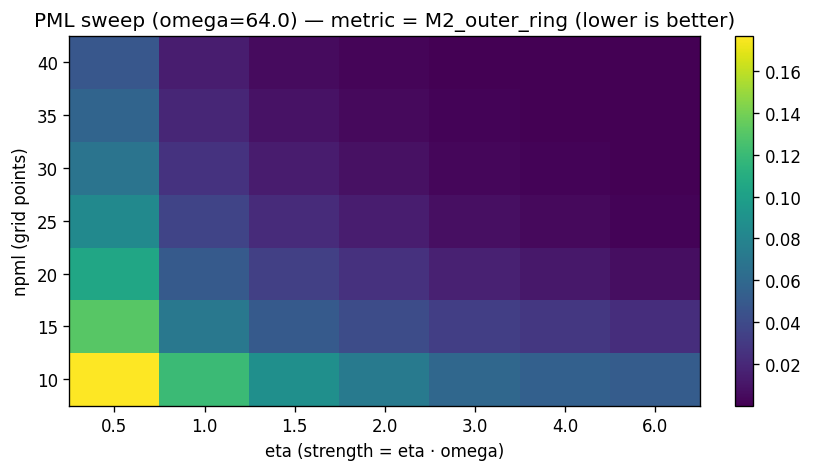

Best in sweep: npml=40, eta=6.0, score=2.320e-05


In [31]:

plt.figure(figsize=(7.5, 4))
plt.imshow(scores, origin="lower", aspect="auto")
plt.xticks(range(len(eta_list)), [str(e) for e in eta_list])
plt.yticks(range(len(npml_list)), [str(v) for v in npml_list])
plt.xlabel("eta (strength = eta · omega)")
plt.ylabel("npml (grid points)")
plt.title(f"PML sweep (omega={omega}) — metric = M2_outer_ring (lower is better)")
plt.colorbar(fraction=0.046)
plt.show()

best = np.unravel_index(np.nanargmin(scores), scores.shape)
best_npml = npml_list[best[0]]
best_eta  = eta_list[best[1]]
print(f"Best in sweep: npml={best_npml}, eta={best_eta}, score={scores[best]:.3e}")

## 8) Debug the best candidate (visual lock-in)


--- Helmholtz solution with PML — BEST ---
Residual norms: {'||r||2': 1.5987176450983058e-14, '||f||2': 1.0, '||r||2/||f||2': 1.5987176450983058e-14, '||u||2': 0.00016350372832702001, '||r||inf': 8.311972382954801e-15}
Metrics:
  M1_core_ring: 1.028e-01
  M2_outer_ring: 2.320e-05
  M3_decay_ratio: 1.909e-05


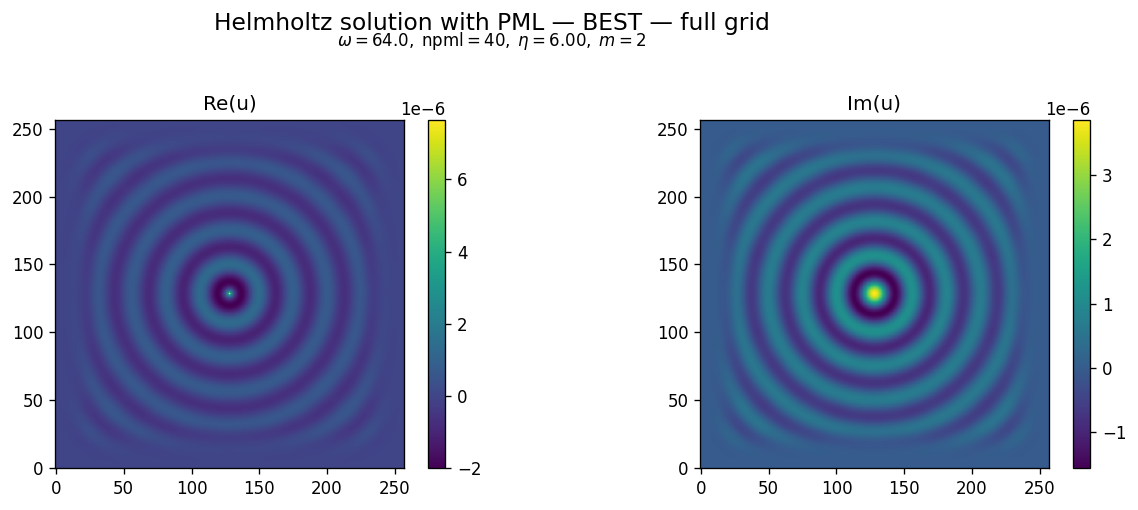

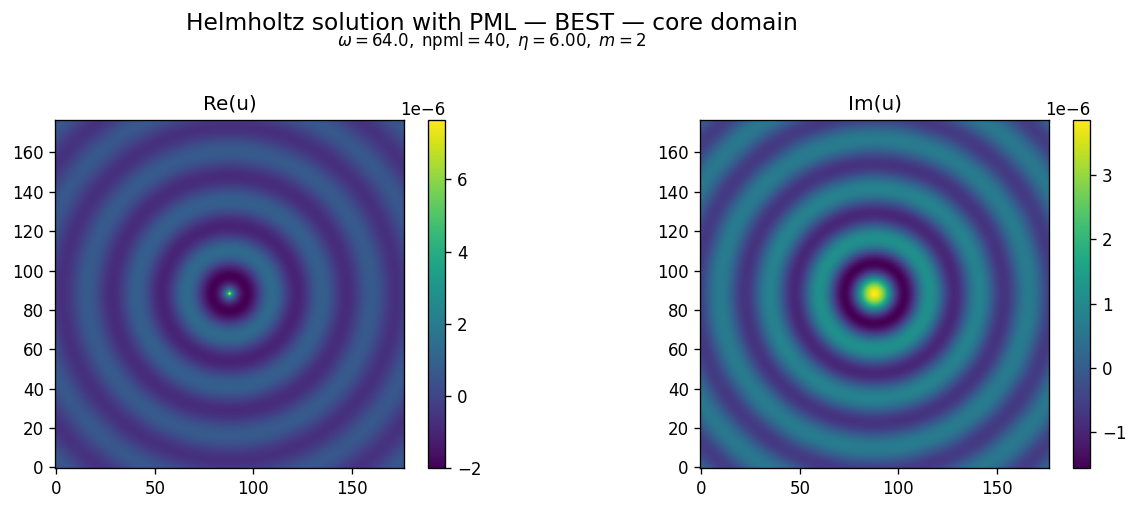

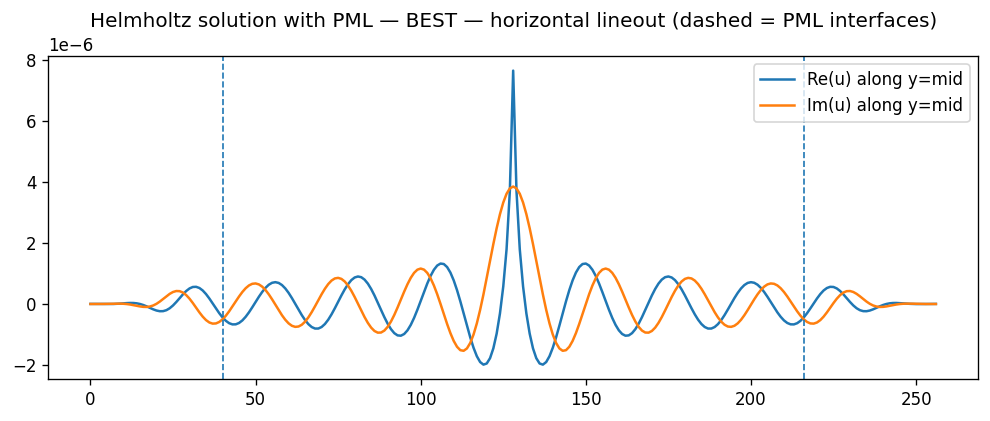

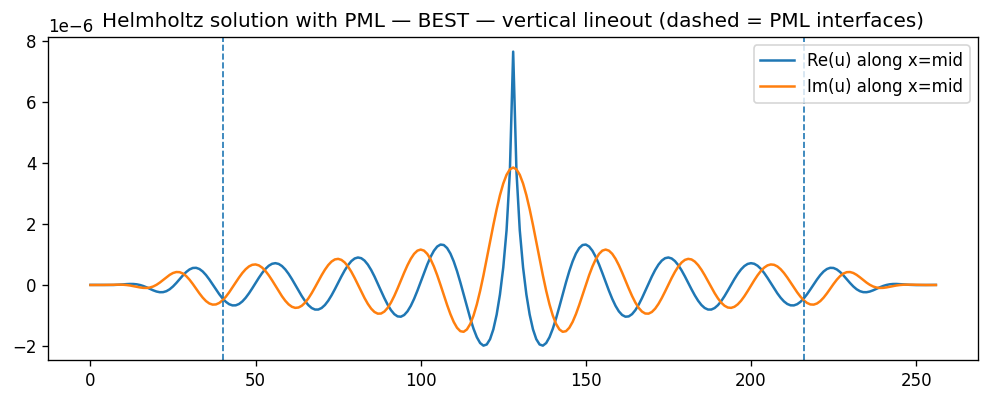

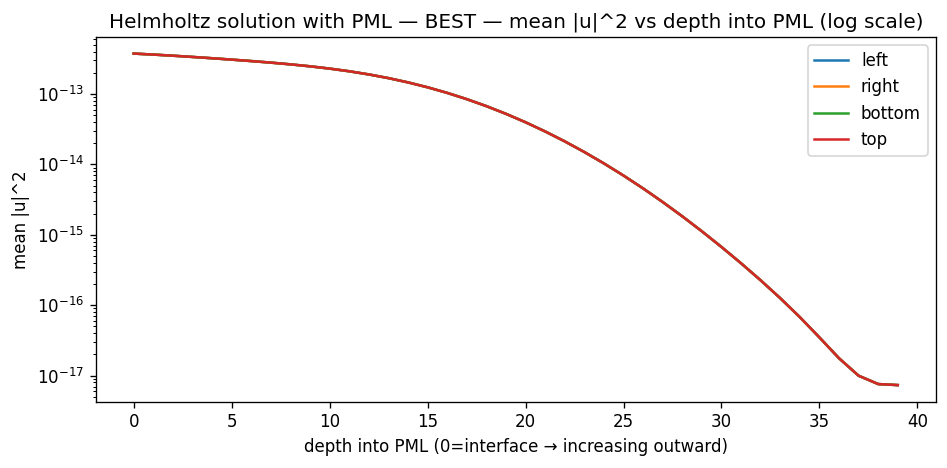

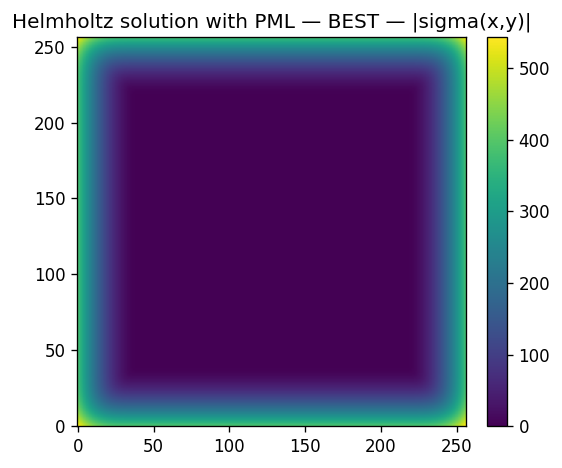

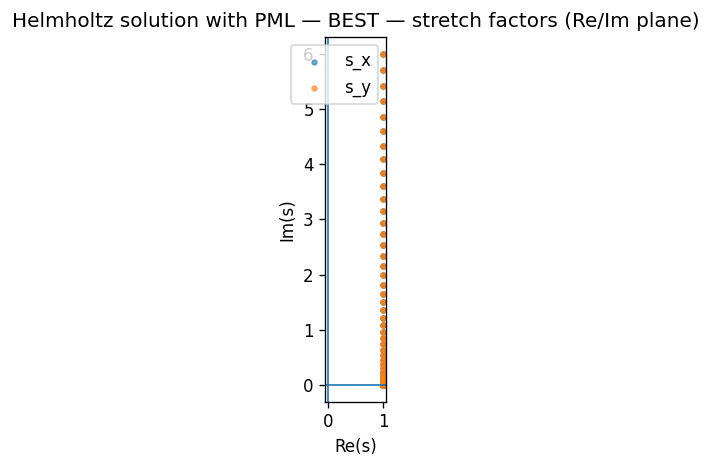


No-PML baseline metrics:
  M1_core_ring: 9.271e-02
  M2_outer_ring: 9.271e-02
  M3_decay_ratio: nan
Improvement (noPML / PML):
  M2_outer_ring: 3996.99x
  M3_decay_ratio: nanx

BEST summary:
  M1_core_ring  : 1.028e-01
  M2_outer_ring : 2.320e-05
  M3_decay_ratio: 1.909e-05
  residual (||r||2/||f||2): 1.599e-14


In [33]:
# --- BEST PML configuration (locked candidate) ---

npml = int(best_npml)
eta  = float(best_eta)
m    = 2

cfg_best = HelmholtzConfig(
    omega=float(omega),
    grid=grid,
    pml=PMLConfig(
        thickness=npml,
        strength=float(eta * omega),
        power=float(m),
    ),
    ppw_target=10.0,
)

title = "Helmholtz solution with PML — BEST"
subtitle = rf"$\omega={float(omega):.1f},\;\mathrm{{npml}}={npml},\;\eta={eta:.2f},\;m={m}$"

U, mets, norms = debug_pml_run(
    cfg_best,
    c=c,
    f=f,
    npml=npml,
    omega=float(omega),
    eta=float(eta),
    m=int(m),
    title=title,
    compare_no_pml=True,
    ring=8,
    outer_ring=8,
)

print("\nBEST summary:")
print(f"  M1_core_ring  : {mets['M1_core_ring']:.3e}")
print(f"  M2_outer_ring : {mets['M2_outer_ring']:.3e}")
print(f"  M3_decay_ratio: {mets['M3_decay_ratio']:.3e}")
print(f"  residual (||r||2/||f||2): {norms.get('||r||2/||f||2', np.nan):.3e}")


## 9) Repeat for all ω in {32, 64, 128}

Once you're happy with a PML choice for ω=64, repeat quickly for ω=32 and ω=128.
You can either keep `npml, eta` fixed or re-sweep per omega.

Below: fixed-parameter check across all omegas.


Validating fixed PML parameters across omegas
---------------------------------------------------------------

--- Helmholtz solution with PML — fixed parameters ---
Residual norms: {'||r||2': 1.2883241056327246e-14, '||f||2': 1.0, '||r||2/||f||2': 1.2883241056327246e-14, '||u||2': 0.0002456986494529096, '||r||inf': 7.183414299618756e-15}
Metrics:
  M1_core_ring: 9.956e-02
  M2_outer_ring: 2.501e-03
  M3_decay_ratio: 1.983e-02


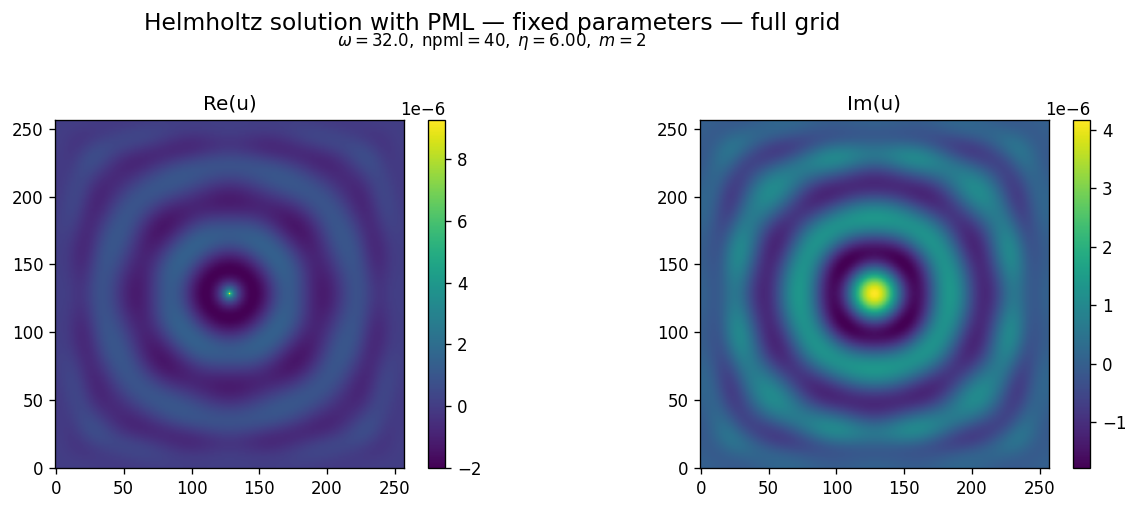

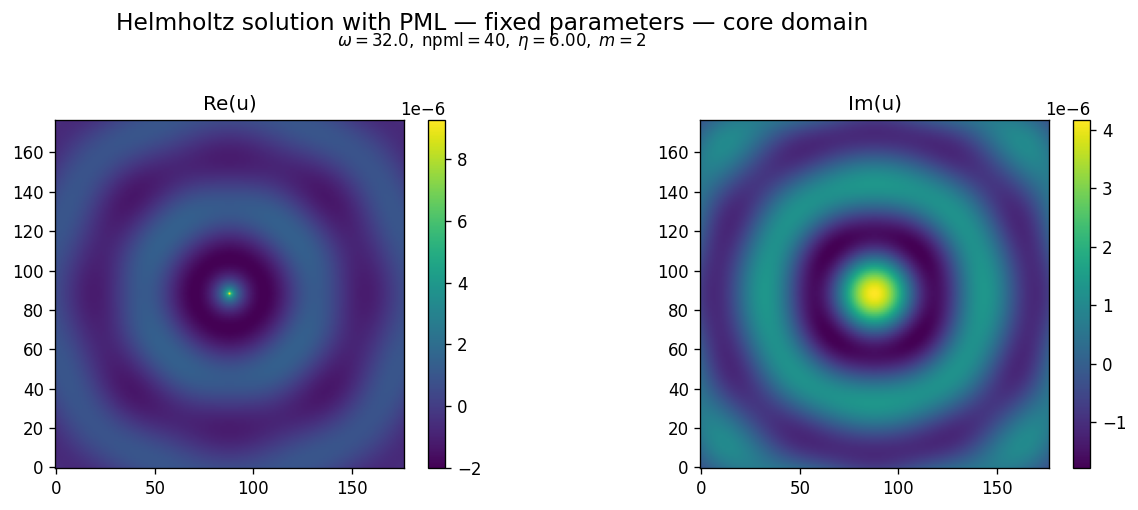

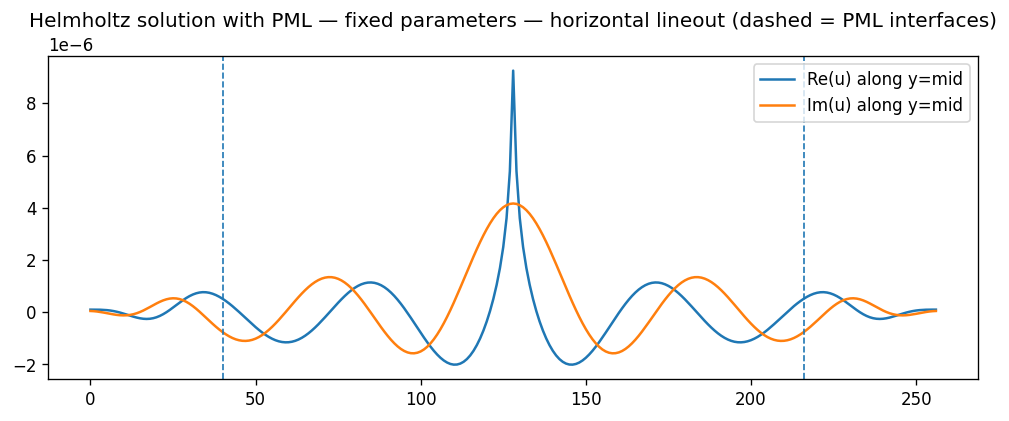

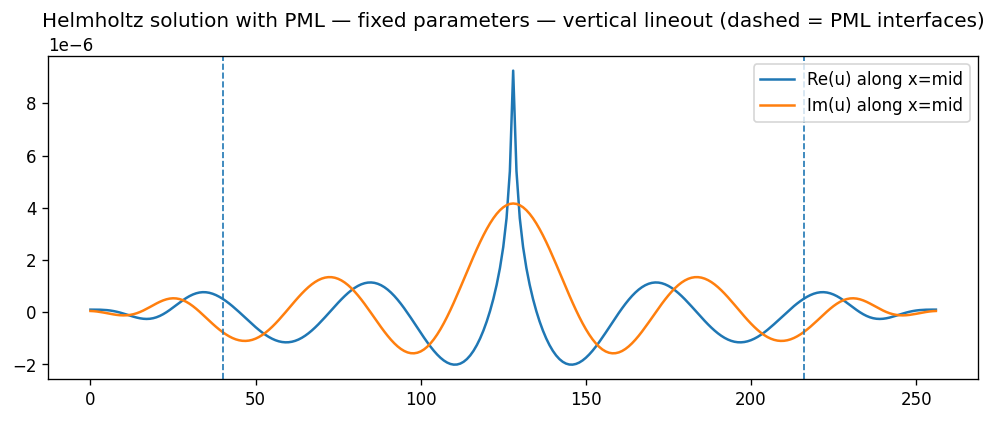

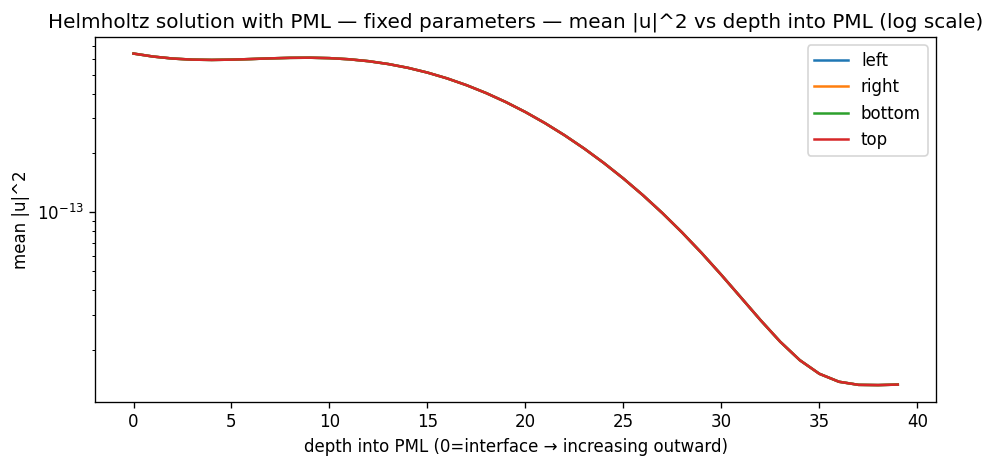

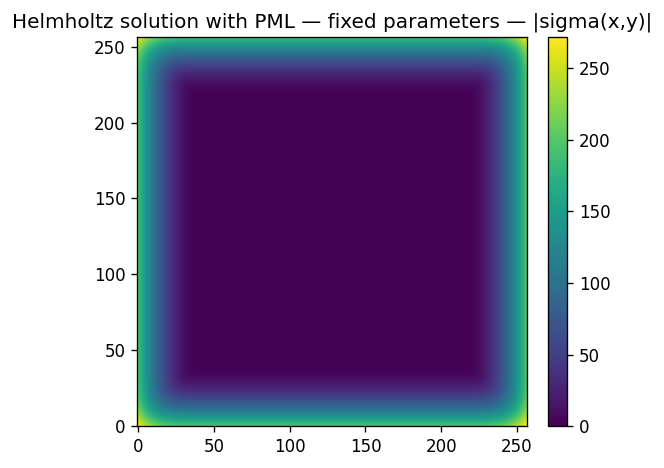

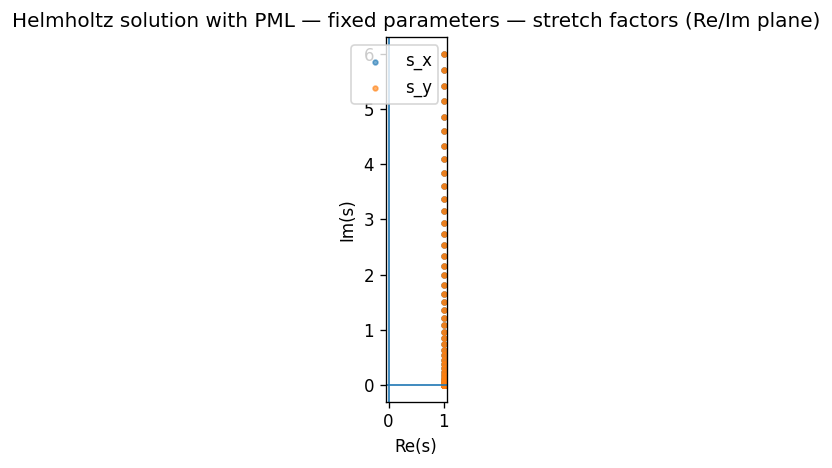

ω=  32.0 | M1=9.96e-02  M2=2.50e-03  M3=1.98e-02  res=1.29e-14

--- Helmholtz solution with PML — fixed parameters ---
Residual norms: {'||r||2': 1.5987176450983058e-14, '||f||2': 1.0, '||r||2/||f||2': 1.5987176450983058e-14, '||u||2': 0.00016350372832702001, '||r||inf': 8.311972382954801e-15}
Metrics:
  M1_core_ring: 1.028e-01
  M2_outer_ring: 2.320e-05
  M3_decay_ratio: 1.909e-05


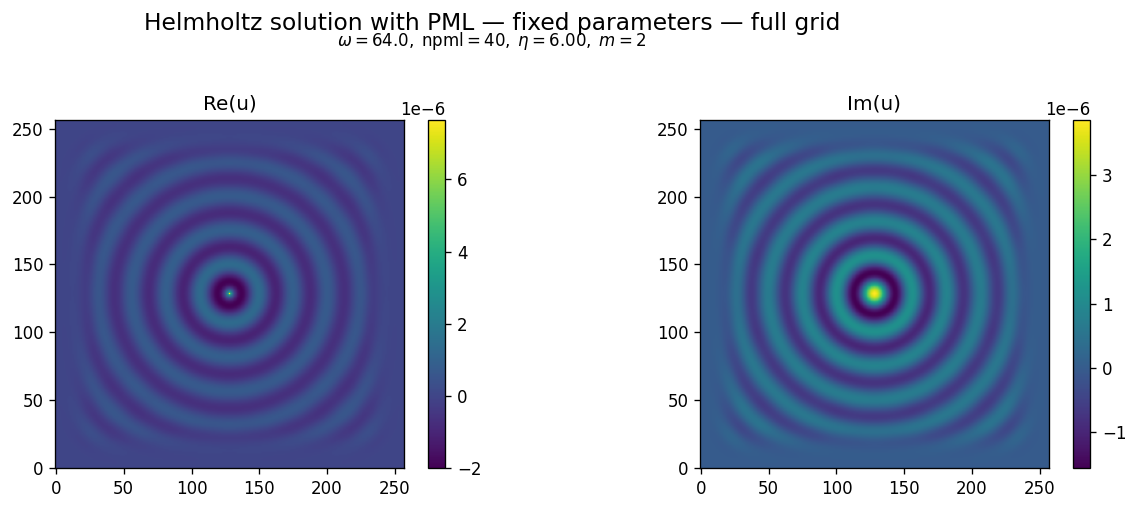

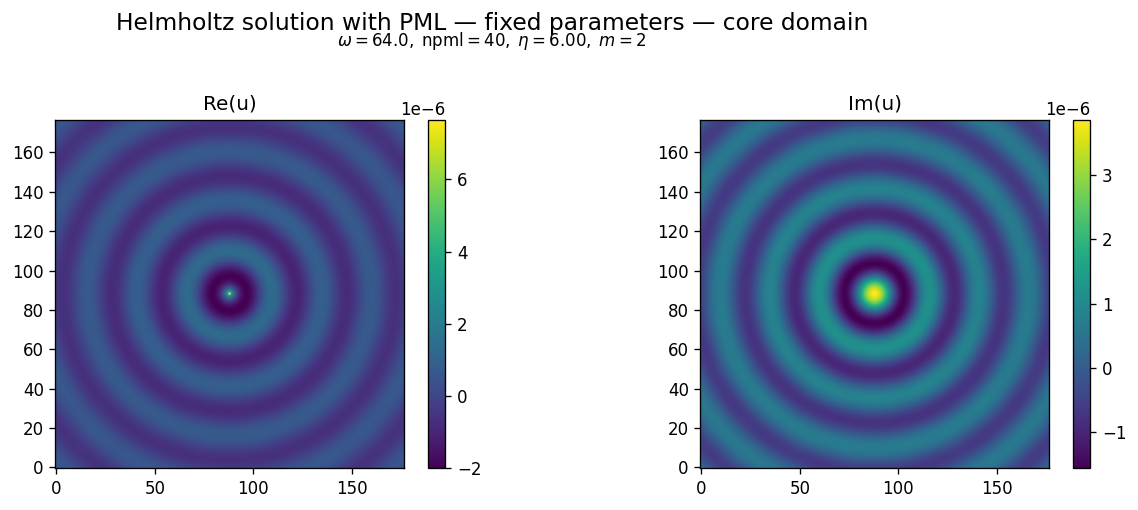

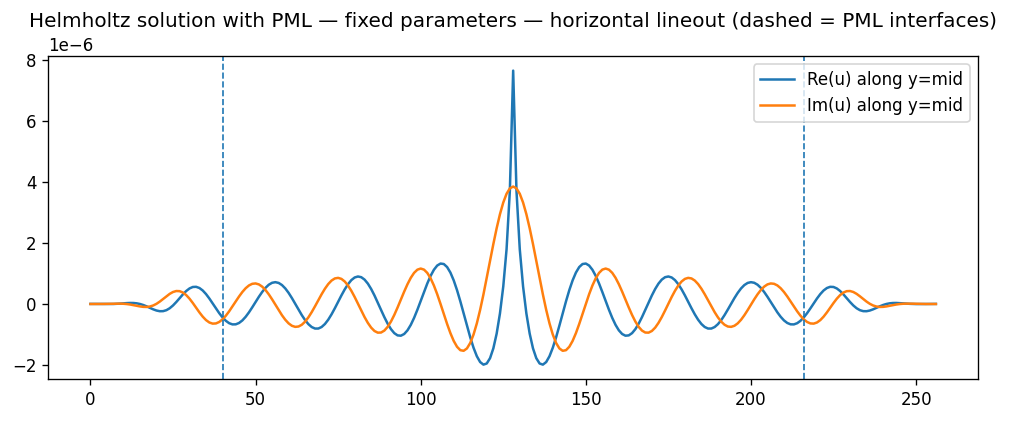

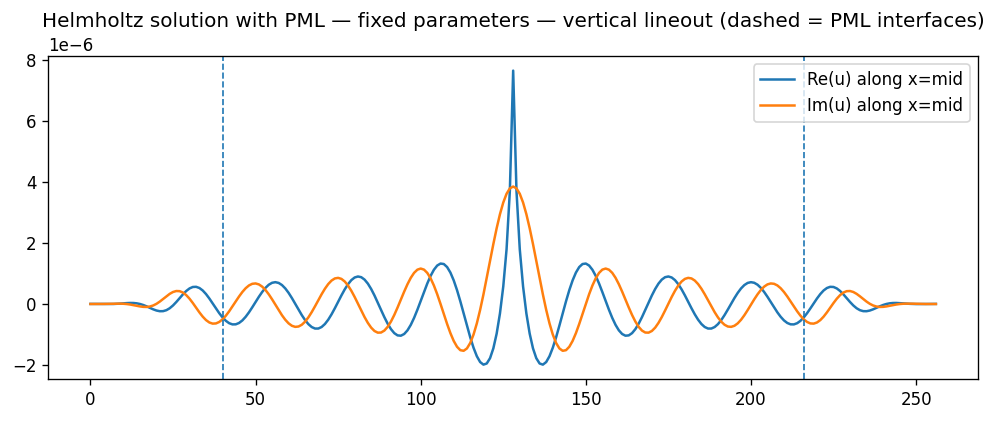

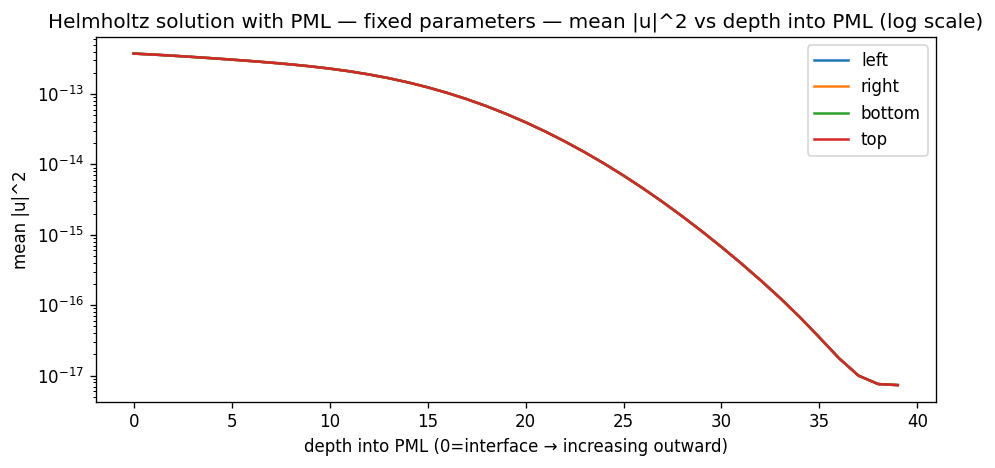

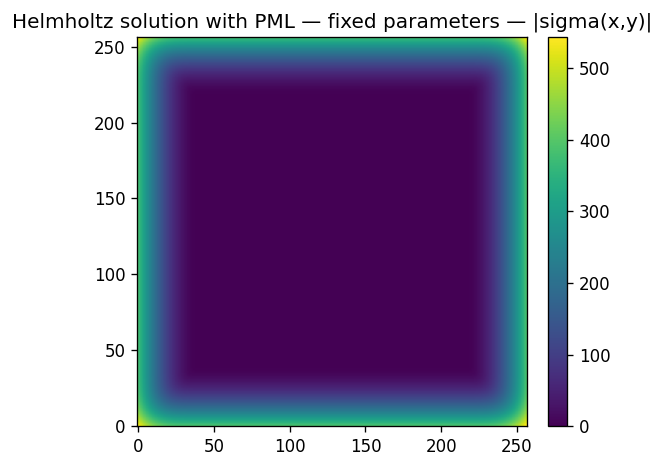

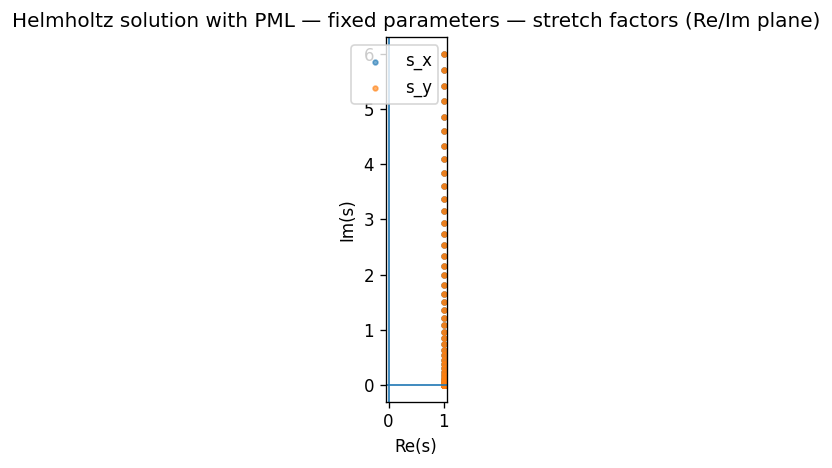

ω=  64.0 | M1=1.03e-01  M2=2.32e-05  M3=1.91e-05  res=1.60e-14

--- Helmholtz solution with PML — fixed parameters ---
Residual norms: {'||r||2': 1.9660846244421093e-14, '||f||2': 1.0, '||r||2/||f||2': 1.9660846244421093e-14, '||u||2': 0.00011664693211667645, '||r||inf': 4.765753620858259e-15}
Metrics:
  M1_core_ring: 9.999e-02
  M2_outer_ring: 5.872e-09
  M3_decay_ratio: 2.817e-11


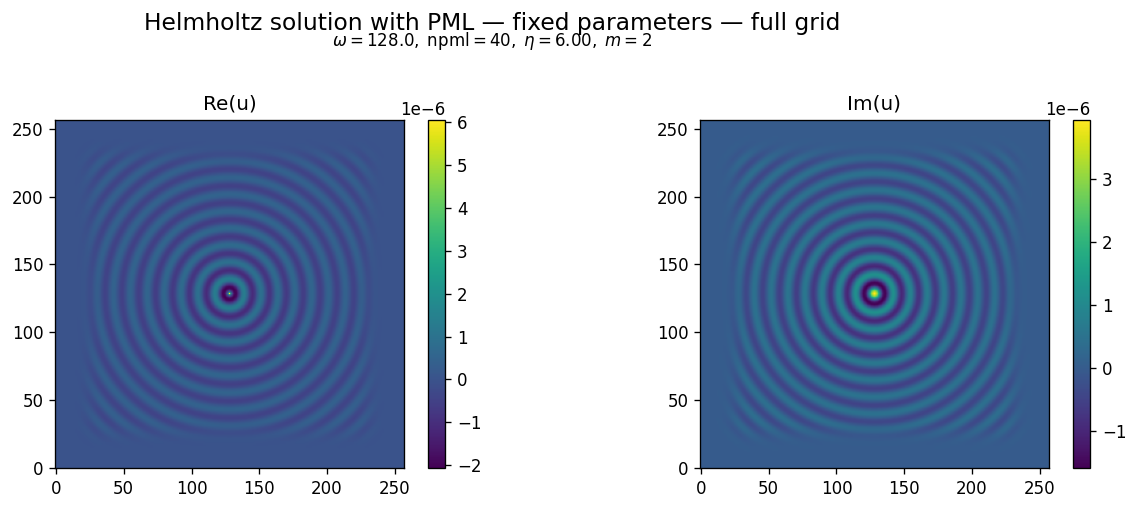

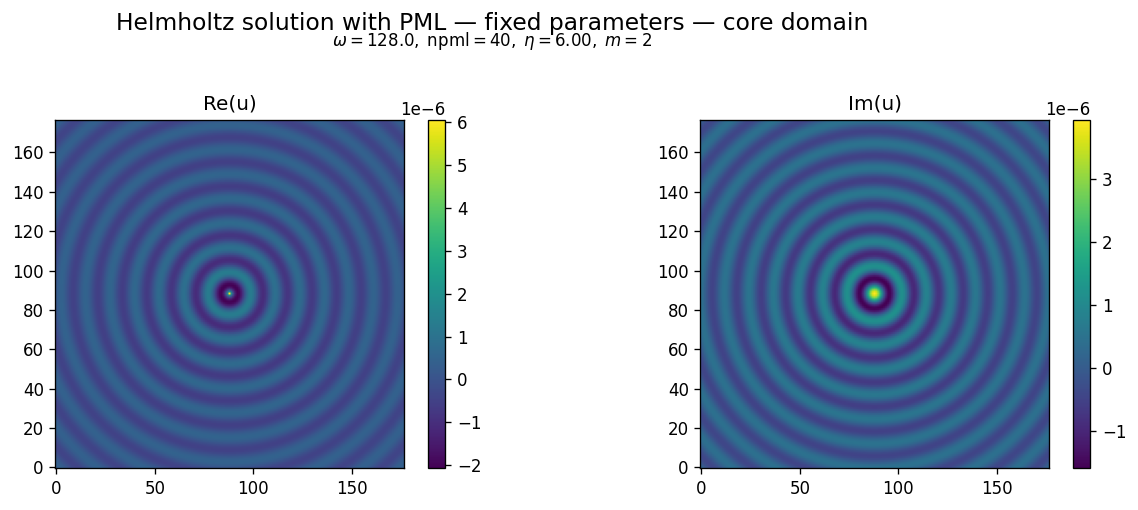

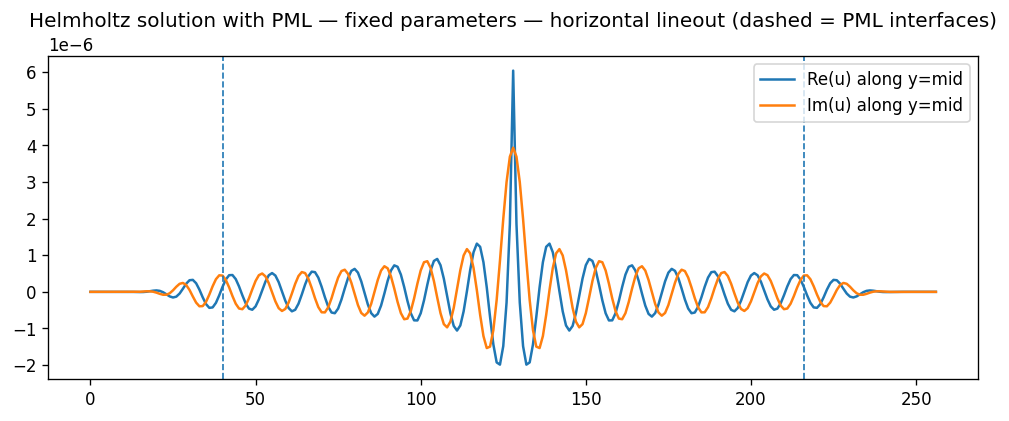

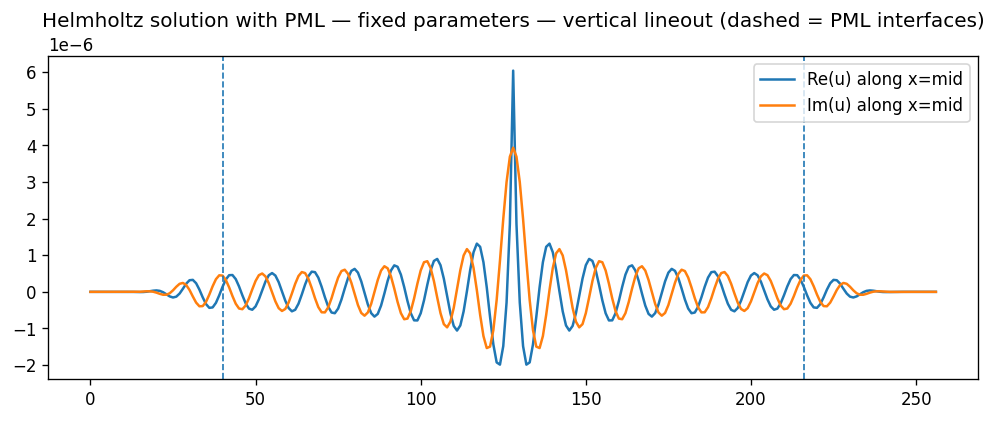

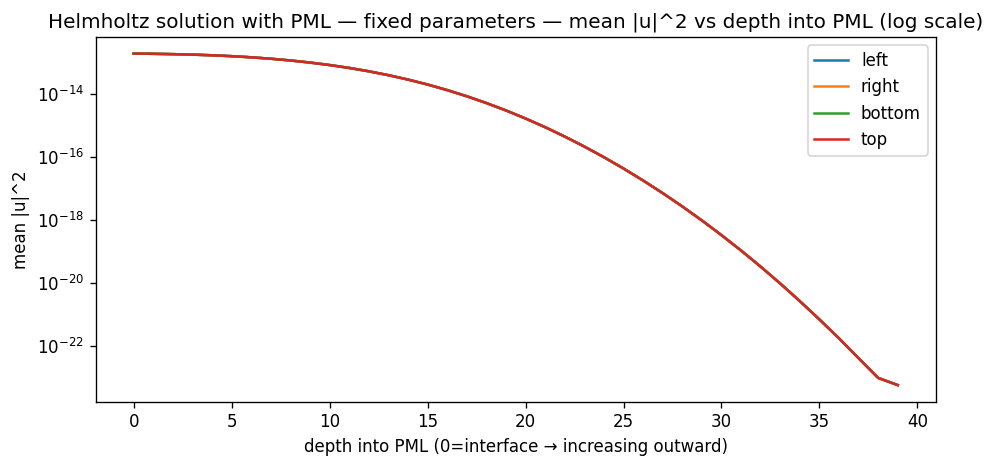

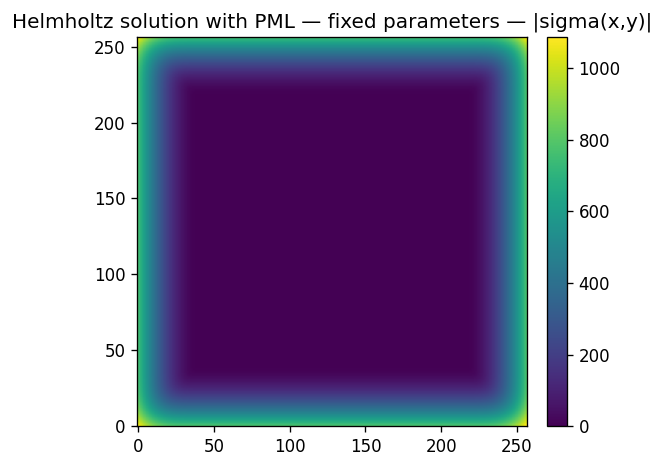

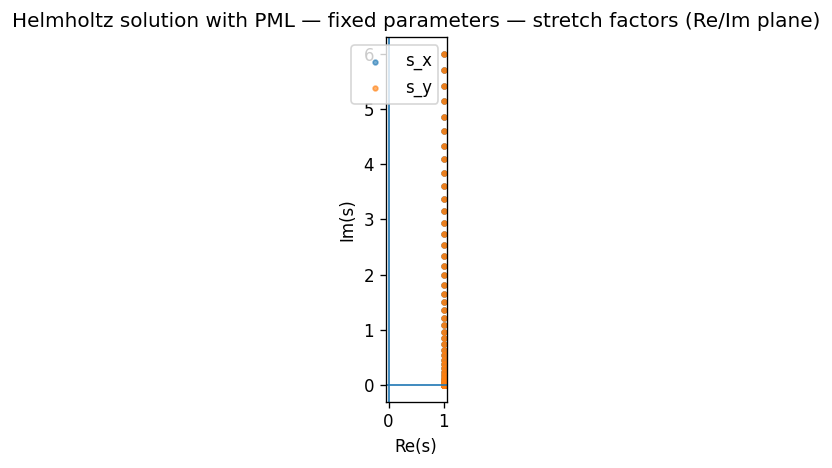

ω= 128.0 | M1=1.00e-01  M2=5.87e-09  M3=2.82e-11  res=1.97e-14
---------------------------------------------------------------
Done.


In [34]:
# --- Validate BEST PML parameters across omegas ---

NPML_FIXED = int(best_npml)
ETA_FIXED  = float(best_eta)
m = 2

print("\nValidating fixed PML parameters across omegas")
print("---------------------------------------------------------------")

for w in OMEGAS:
    # Base config (for medium + RHS)
    cfg_base = HelmholtzConfig(
        omega=float(w),
        grid=grid,
        pml=None,
        ppw_target=10.0,
    )

    X, Y = grid.mesh()
    c = build_medium(cfg_base, case, X, Y)
    f = assemble_rhs(cfg_base, case, X, Y)

    # PML config
    cfg_pml = HelmholtzConfig(
        omega=float(w),
        grid=grid,
        pml=PMLConfig(
            thickness=NPML_FIXED,
            strength=float(ETA_FIXED * w),
            power=float(m),
        ),
        ppw_target=10.0,
    )

    title = "Helmholtz solution with PML — fixed parameters"
    subtitle = rf"$\omega={w:.1f},\;\mathrm{{npml}}={NPML_FIXED},\;\eta={ETA_FIXED:.2f},\;m={m}$"

    # Run full debug (plots + metrics)
    U, mets, norms = debug_pml_run(
        cfg_pml,
        c=c,
        f=f,
        npml=NPML_FIXED,
        omega=float(w),
        eta=float(ETA_FIXED),
        m=int(m),
        title=title,
        compare_no_pml=False,  # keep output manageable in a loop
    )

    # Compact numeric summary
    print(
        f"ω={w:>6.1f} | "
        f"M1={mets['M1_core_ring']:.2e}  "
        f"M2={mets['M2_outer_ring']:.2e}  "
        f"M3={mets['M3_decay_ratio']:.2e}  "
        f"res={norms.get('||r||2/||f||2', np.nan):.2e}"
    )

print("---------------------------------------------------------------")
print("Done.")
